In [115]:
from super_gradients.training import models
import cv2
import sys
sys.path.append('..')
from anns import Detection
import matplotlib.pyplot as plt
import numpy as np


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
CLASSES = [
    "1",
    "10",
    "11",
    "12",
    "13",
    "14",
    "15",
    "16",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "c",
]
NUM_CLASES = len(CLASSES)

In [5]:
model = models.get("yolo_nas_l",
                        num_classes=NUM_CLASES,
                        checkpoint_path="/home/fer/Escritorio/futstatistics/yolo_nas/checkpoints/FIELD_HOMOGRAPHY/ckpt_best.pth")

[2023-09-24 00:15:34] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/fer/Escritorio/futstatistics/yolo_nas/checkpoints/FIELD_HOMOGRAPHY/ckpt_best.pth EMA checkpoint.


In [6]:
img = cv2.cvtColor(cv2.imread('field.png'), cv2.COLOR_BGR2RGB)#

In [7]:
results = list(model.predict(img, conf=0.25))[0]
detections = Detection.from_yoloNas(pred=results)

[2023-09-24 00:15:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


In [8]:
detections

[Detection(rect=Rect(x=6.277492523193359, y=447.4559020996094, width=28.667518615722656, height=36.916351318359375), class_id=6, class_name='15', confidence=0.7045174837112427, tracker_id=None, color=None),
 Detection(rect=Rect(x=788.0101928710938, y=210.60060119628906, width=17.2198486328125, height=21.641693115234375), class_id=15, class_name='9', confidence=0.6821118593215942, tracker_id=None, color=None),
 Detection(rect=Rect(x=1289.7734375, y=437.33160400390625, width=23.4703369140625, height=31.571441650390625), class_id=3, class_name='12', confidence=0.6706815361976624, tracker_id=None, color=None),
 Detection(rect=Rect(x=892.4678955078125, y=259.5836486816406, width=17.4552001953125, height=20.681121826171875), class_id=1, class_name='10', confidence=0.6313509941101074, tracker_id=None, color=None),
 Detection(rect=Rect(x=1105.309814453125, y=238.08750915527344, width=16.2698974609375, height=17.640106201171875), class_id=13, class_name='7', confidence=0.6302385926246643, track

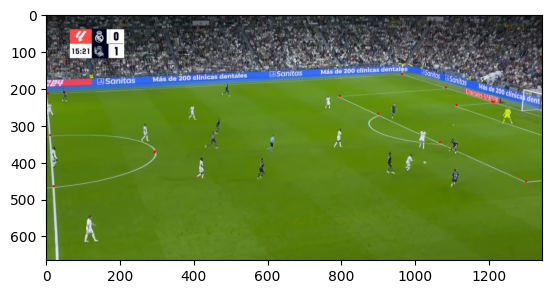

In [13]:
field = cv2.cvtColor(cv2.imread('field_2d.jpg'), cv2.COLOR_BGR2RGB)

points = img.copy()

for detection in detections:
    x2, y2 = detection.rect.bottom_right.int_xy_tuple
    x1, y1 = detection.rect.top_left.int_xy_tuple
    # get the center of the box
    center = (int((x1 + x2) / 2),int((y1 + y2) / 2))
    points = cv2.circle(points, center, 3, (255, 0, 0), -1)


plt.imshow(points)

In [107]:
POINT2POINT2D = {
    "1" : (60, 60),
    "2" : (310, 60),
    "3" : (520, 60),
    "4" : (850, 60),
    "5" : (1050, 60),
    "6" : (1300, 60),
    "9" : (310,360),
    "10" : (550,360),
    "11" : (820, 360),
    "12" : (1050, 360),
    "13": (60, 1020),
    "14" : (680, 1020),
    "15" : (860, 1020),
    "16" : (1300, 1020),
    "c" : (680, 850),
}

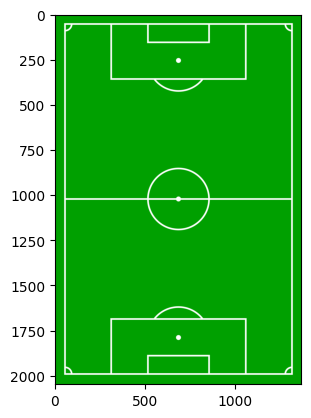

In [145]:
field = cv2.cvtColor(cv2.imread('field_2d.jpg'), cv2.COLOR_BGR2RGB)


plt.imshow(field)

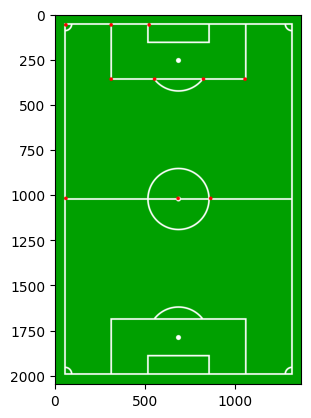

In [153]:
src_points = []
dst_ponts = []


anns_2d = field.copy()


for detection in detections:
    x2, y2 = detection.rect.bottom_right.int_xy_tuple
    x1, y1 = detection.rect.top_left.int_xy_tuple
    # get the center of the box
    center = (int((x1 + x2) / 2),int((y1 + y2) / 2))
    if str(detection.class_name) in POINT2POINT2D:
        points_2d = POINT2POINT2D[str(detection.class_name)]
        src_points.append(center)
        dst_ponts.append(points_2d)
        anns_2d = cv2.circle(anns_2d,points_2d, 10, (255, 0, 0), -1)


plt.imshow(anns_2d)

In [147]:
H, status = cv2.findHomography(np.array(src_points), np.array(dst_ponts))


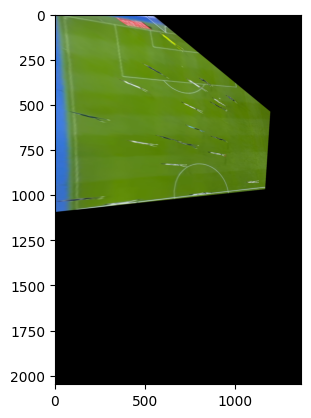

In [154]:
im_out = cv2.warpPerspective(img, H, (field.shape[1],field.shape[0]))
plt.imshow(im_out)

In [155]:
BALL = (1035, 400)
ball_pts = np.array([BALL],np.float32).reshape(-1,1,2)

In [156]:
M =  cv2.getPerspectiveTransform(np.array(src_points, np.float32)[:4],np.array(dst_ponts, np.float32)[:4])

In [157]:
ball_pts_2d = cv2.perspectiveTransform(ball_pts,M)
ball_pts_2d = ball_pts_2d.astype(int)

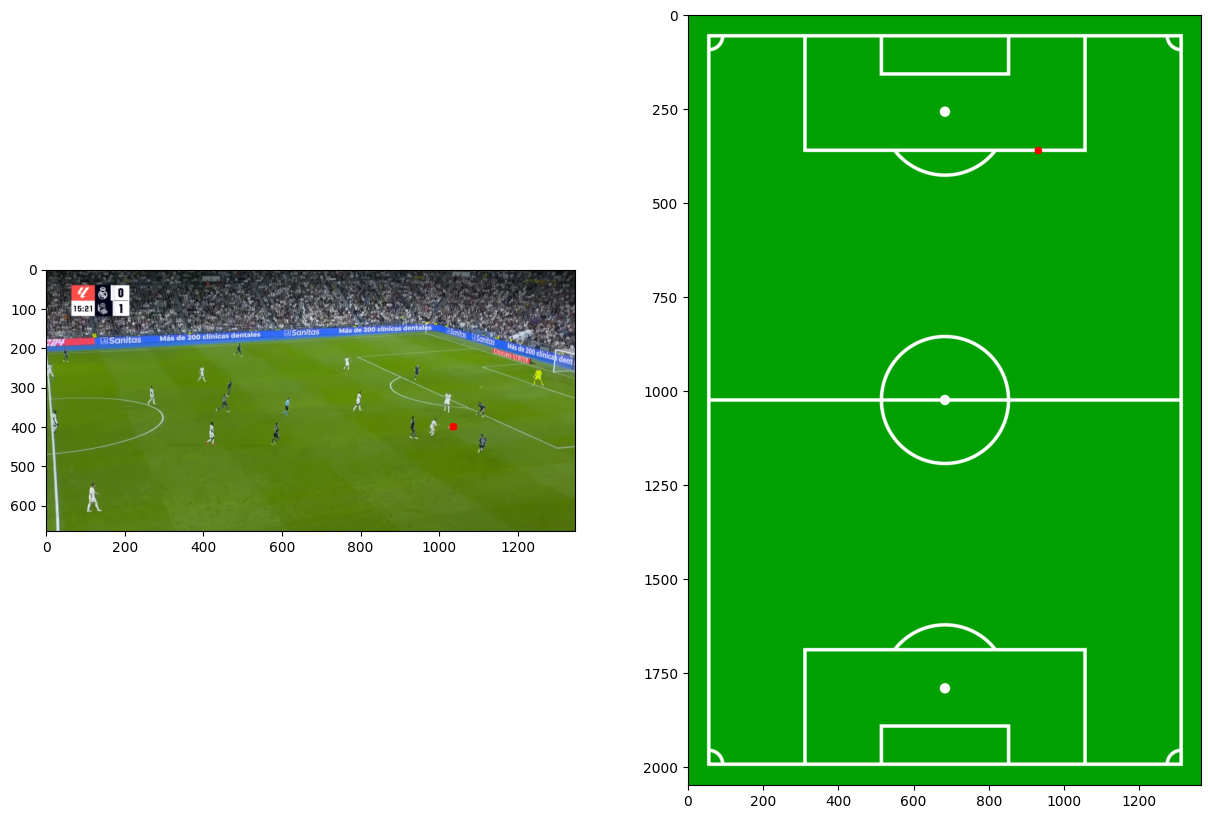

In [158]:
ball = img.copy()
ball = cv2.circle(ball, BALL, 10, (255, 0, 0), -1)

ball_2d = field.copy()
ball_2d = cv2.circle(ball_2d, tuple(ball_pts_2d[0][0]), 10, (255, 0, 0), -1)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(ball)
ax[1].imshow(ball_2d)